In this project, we'll build a simple convolutional neural network for CIFAR-10 image classification. Code contained in this project was based on Tensorflow 1.2.1 and python 3.5. 

In [1]:
from urllib.request import urlretrieve
from os.path import isfile, isdir
from tqdm import tqdm
import tarfile
import tensorflow as tf

cifar10_dataset_folder_path = 'cifar-10-batches-py'
tar_gz_path = 'cifar-10-python.tar.gz'

class DLProgress(tqdm):
    last_block = 0

    def hook(self, block_num=1, block_size=1, total_size=None):
        self.total = total_size
        self.update((block_num - self.last_block) * block_size)
        self.last_block = block_num

if not isfile(tar_gz_path):
    with DLProgress(unit='B', unit_scale=True, miniters=1, desc='CIFAR-10 Dataset') as pbar:
        urlretrieve(
            'https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz',
            tar_gz_path,
            pbar.hook)

if not isdir(cifar10_dataset_folder_path):
    with tarfile.open(tar_gz_path) as tar:
        tar.extractall()
        tar.close()


Stats of batch 1:
Samples: 10000
Label Counts: {0: 1005, 1: 974, 2: 1032, 3: 1016, 4: 999, 5: 937, 6: 1030, 7: 1001, 8: 1025, 9: 981}
First 20 Labels: [6, 9, 9, 4, 1, 1, 2, 7, 8, 3, 4, 7, 7, 2, 9, 9, 9, 3, 2, 6]

Example of Image 6:
Image - Min Value: 7 Max Value: 249
Image - Shape: (32, 32, 3)
Label - Label Id: 2 Name: bird


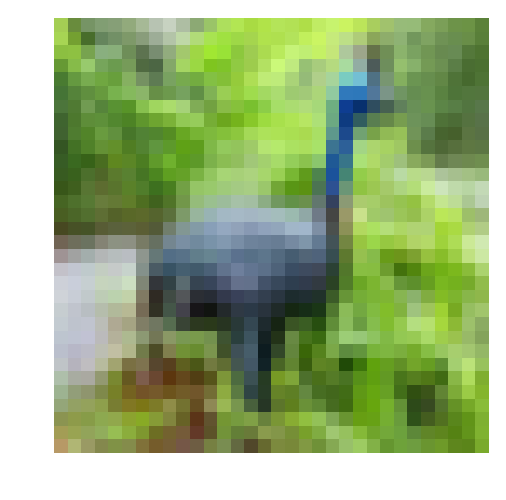

In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import helper
import numpy as np

# Explore the dataset
batch_id = 1
sample_id = 6
helper.display_stats(cifar10_dataset_folder_path, batch_id, sample_id)

# Preprocess Data

## Normalize

In [3]:
def normalize(x):
    """
    Normalize a list of sample image data in the range of 0 to 1
    : x: List of image data.  The image shape is (32, 32, 3)
    """
    return (x - np.mean(x)) / np.std(x)
    # return ( x - x.min() ) / ( x.max() - x.min() )

## One hot encode

In [4]:
def one_hot_encode(x):
    """
    One hot encode a list of sample labels. Return a one-hot encoded vector for each label.
    : x: List of sample Labels
    : return: Numpy array of one-hot encoded labels
    """
    output = np.zeros([len(x), 10])
    for idx, item in enumerate(x):
        output[idx, item] = 1
    return output

This above function is equivalent to tf.one_hot(x, 10), but tensorflow module can not be pickled so we're sticking with the above implementation.

## Preprocess Data
We will randomly shuffle the data, normalize them and save them in binary format.

In [5]:
import tensorflow as tf
# Preprocess Training, Validation, and Testing Data
helper.preprocess_and_save_data(cifar10_dataset_folder_path, normalize, one_hot_encode)

# Checkpoint
The above work is all saved so when we're revisiting this notebook we don't have to do those work again. We can start from here.

In [6]:
import pickle
import helper

valid_features, valid_labels = pickle.load(open('preprocess_validation.p', mode='rb'))

# Building the network

## Defining input

In [7]:
import tensorflow as tf

def neural_net_image_input(image_shape):
    """
    Return a Tensor for a batch of image input
    : image_shape: Shape of the images
    """
    return tf.placeholder(tf.float32, [None, image_shape[0], image_shape[1], image_shape[2]], "x")


def neural_net_label_input(n_classes):
    """
    Return a Tensor for a batch of label input
    : n_classes: Number of classes
    """
    return tf.placeholder(tf.float32, [None, n_classes], "y")


def neural_net_keep_prob_input():
    """
    Return a Tensor for keep probability
    """
    return tf.placeholder(tf.float32, None, "keep_prob")


def neural_net_training_flag():
    return tf.placeholder(tf.bool, None, "train_flag")

## Convolution and maxpool layer

In [8]:
def conv2d_maxpool(x_tensor, conv_num_outputs, conv_ksize, conv_strides, pool_ksize, pool_strides, is_train, maxpool=True):
    """
    Apply convolution then max pooling to x_tensor
    :param x_tensor: TensorFlow Tensor
    :param conv_num_outputs: Number of outputs for the convolutional layer
    :param conv_ksize: kernal size 2-D Tuple for the convolutional layer
    :param conv_strides: Stride 2-D Tuple for convolution
    :param pool_ksize: kernal size 2-D Tuple for pool
    :param pool_strides: Stride 2-D Tuple for pool
    : return: A tensor that represents convolution and max pooling of x_tensor
    """
    w = tf.get_variable("w", shape=[conv_ksize[0], conv_ksize[1], x_tensor.get_shape().as_list()[3], conv_num_outputs],
                         initializer=tf.contrib.layers.xavier_initializer())
    
    #b = tf.Variable(tf.truncated_normal([conv_num_outputs],
    #                                  mean=0.0, stddev=0.1, dtype=tf.float32))
    
    wc = tf.nn.conv2d(x_tensor, w, strides=[1, conv_strides[0], conv_strides[1], 1], padding='SAME')
    # z = tf.nn.bias_add(wc, b)
    z = tf.layers.batch_normalization(wc, training=is_train)
    
    if maxpool==True:
        z = tf.nn.max_pool(z, ksize=[1, pool_ksize[0], pool_ksize[1], 1], 
                           strides=[1, pool_strides[0], pool_strides[1], 1], padding='SAME')
    
    return tf.nn.relu(z)



## Flatten layer
Implement the flatten function to change the dimension of x_tensor from a 4-D tensor to a 2-D tensor. The output should be the shape (Batch Size, Flattened Image Size). Shortcut option: you can use classes from the TensorFlow Layers or TensorFlow Layers (contrib) packages for this layer. For more of a challenge, only use other TensorFlow packages.

In [9]:
def flatten(x_tensor):
    """
    Flatten x_tensor to (Batch Size, Flattened Image Size)
    : x_tensor: A tensor of size (Batch Size, ...), where ... are the image dimensions.
    : return: A tensor of size (Batch Size, Flattened Image Size).
    """
    # reference : https://github.com/tensorflow/tensorflow/issues/7253
    return tf.reshape(x_tensor, [tf.shape(x_tensor)[0], np.prod(x_tensor.get_shape().as_list()[1:])])
    
    # This also works
    #return tf.reshape(x_tensor, [-1, np.prod(x_tensor.shape[1:]).value])

## Fully connected layer

In [10]:
def fully_conn(x_tensor, num_outputs, is_train):
    """
    Apply a fully connected layer to x_tensor using weight and bias
    : x_tensor: A 2-D tensor where the first dimension is batch size.
    : num_outputs: The number of output that the new tensor should be.
    : return: A 2-D tensor where the second dimension is num_outputs.
    """
    fc = tf.reshape(x_tensor, [-1, np.prod(x_tensor.get_shape().as_list()[1:])])
    
    w = tf.get_variable("w", shape=[np.prod(x_tensor.get_shape().as_list()[1:]), num_outputs],
                         initializer=tf.contrib.layers.xavier_initializer())
    
    # b = tf.Variable(tf.truncated_normal([num_outputs],mean=0.0, stddev=0.1, dtype=tf.float32))
    z = tf.matmul(fc, w)
    z = tf.layers.batch_normalization(z, training=is_train)
    
    return tf.nn.relu(z)

## Output layer

In [11]:
def output(x_tensor, num_outputs):
    """
    Apply a output layer to x_tensor using weight and bias
    : x_tensor: A 2-D tensor where the first dimension is batch size.
    : num_outputs: The number of output that the new tensor should be.
    : return: A 2-D tensor where the second dimension is num_outputs.
    """
    w = tf.get_variable("w", shape=[np.prod(x_tensor.get_shape().as_list()[1:]), num_outputs],
                         initializer=tf.contrib.layers.xavier_initializer())
    
    b = tf.Variable(tf.truncated_normal([num_outputs],mean=0.0, stddev=0.1, dtype=tf.float32))
    return tf.add(tf.matmul(x_tensor, w), b)


## Create the convolutional neural network model

In [12]:
def conv_net(x, keep_prob, train_flag):
    """
    Create a convolutional neural network model
    : x: Placeholder tensor that holds image data.
    : keep_prob: Placeholder tensor that hold dropout keep probability.
    : return: Tensor that represents logits
    """
    # Convolution and maxpooling layers
    with tf.variable_scope("conv1"):
        conv1 = conv2d_maxpool(x, 40, (3, 3), (1, 1), (2, 2), (2, 2), train_flag, maxpool=False)
    with tf.variable_scope("conv2"):
        conv2 = conv2d_maxpool(conv1, 80, (3, 3), (1, 1), (2, 2), (2, 2), train_flag, maxpool=True)
    #conv2 = tf.nn.lrn(conv2, 4, bias=1.0, alpha=0.001 / 9.0, beta=0.75,name='norm1')
    conv2 = tf.nn.dropout(conv2, keep_prob)
    with tf.variable_scope("conv3"):
        conv3 = conv2d_maxpool(conv2, 160, (3, 3), (1, 1), (2, 2), (2, 2), train_flag, maxpool=False)
    with tf.variable_scope("conv4"):
        conv4 = conv2d_maxpool(conv3, 320, (3, 3), (1, 1), (2, 2), (2, 2), train_flag, maxpool=True)
    #conv4 = tf.nn.lrn(conv4, 4, bias=1.0, alpha=0.001 / 9.0, beta=0.75,name='norm2')
    conv4 = tf.nn.dropout(conv4, keep_prob)
    with tf.variable_scope("conv5"):
        conv5 = conv2d_maxpool(conv4, 160, (1, 1), (1, 1), (2, 2), (2, 2), train_flag, maxpool=False)
    conv5 = tf.nn.dropout(conv5, keep_prob)
    
    # Flatten Layer
    f = flatten(conv5)

    # Fully Connected layers
    with tf.variable_scope("fc1"):
        fc1 = fully_conn(f, 512, train_flag)
        fc1 = tf.nn.dropout(fc1, keep_prob)
    with tf.variable_scope("fc2"):
        fc2 = fully_conn(fc1, 256, train_flag)
        fc2 = tf.nn.dropout(fc2, keep_prob)
    #with tf.variable_scope("fc3"):
    #    fc3 = fully_conn(fc2, 96, train_flag)
    #    fc3 = tf.nn.dropout(fc3, keep_prob)
    
    # Output Layer
    with tf.variable_scope("out"):
        o = output(fc2, 10)
    
    # TODO: return output
    return o

## Build the network

In [13]:
tf.reset_default_graph()

# Inputs
x = neural_net_image_input((32, 32, 3))
y = neural_net_label_input(10)
keep_prob = neural_net_keep_prob_input()
train_flag = neural_net_training_flag()

# Model
logits = conv_net(x, keep_prob, train_flag)

# Name logits Tensor, so that is can be loaded from disk after training
logits = tf.identity(logits, name='logits')

# Loss and Optimizer
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=y))

# Collect batch mean and variance for batch normalization
update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
with tf.control_dependencies(update_ops):
    optimizer = tf.train.AdamOptimizer(epsilon=1e-04).minimize(cost)

# Accuracy
correct_pred = tf.equal(tf.argmax(logits, 1), tf.argmax(y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32), name='accuracy')

## Train network

In [14]:
def train_neural_network(session, optimizer, keep_probability, feature_batch, label_batch, is_train):
    """
    Optimize the session on a batch of images and labels
    """
    session.run(optimizer, feed_dict={x: feature_batch, y: label_batch, keep_prob: keep_probability, train_flag:is_train})

## Print Stats
It's important to evaluate the performance of model once in a while. If effect, we're feeding a small batch of data to the neural network through forward propagation and then caculate the accuracy of prediction. We don't want to do this too often as this slows down the overall process. It's important to keep in mind that since we're actually using the model for prediction but not training it, we need to set keep probability for dropout to 1 so we're not losing any connection between neurons. 

In [15]:
def print_stats(session, feature_batch, label_batch, cost, accuracy):
    """
    Print information about loss and validation accuracy
    """
    loss = session.run(cost, feed_dict={x: feature_batch, y: label_batch, keep_prob: 1., train_flag:False})
    valid_acc = session.run(accuracy, feed_dict={x: valid_features, y: valid_labels, keep_prob: 1., train_flag:False})
    print('Loss: {:>10.4f} Validation Accuracy: {:.6f}'.format(loss, valid_acc))

## Hyperparameters

In [16]:
epochs = 60
batch_size = 64
keep_probability = 0.5

## Train on a single CIFAR-10 batch

In [17]:
#print('Checking the Training on a Single Batch...')
#with tf.Session() as sess:
#    sess.run(tf.global_variables_initializer())
    
    # Training cycle
#    for epoch in range(epochs):
#        batch_i = 1
#        for batch_features, batch_labels in helper.load_preprocess_training_batch(batch_i, batch_size):
#            train_neural_network(sess, optimizer, keep_probability, batch_features, batch_labels, True)
#        print('Epoch {:>2}, CIFAR-10 Batch {}:  '.format(epoch + 1, batch_i), end='')
#        print_stats(sess, batch_features, batch_labels, cost, accuracy)

## Fully train the model

In [18]:
save_model_path = './image_classification'

print('Training...')
with tf.Session() as sess:
    # Initializing the variables
    sess.run(tf.global_variables_initializer())
    
    # Training cycle
    for epoch in range(epochs):
        # Loop over all batches
        n_batches = 5
        for batch_i in range(1, n_batches + 1):
            for batch_features, batch_labels in helper.load_preprocess_training_batch(batch_i, batch_size):
                train_neural_network(sess, optimizer, keep_probability, batch_features, batch_labels, True)
            print('Epoch {:>2}, CIFAR-10 Batch {}:  '.format(epoch + 1, batch_i), end='')
            print_stats(sess, batch_features, batch_labels, cost, accuracy)
            
    # Save Model
    saver = tf.train.Saver()
    save_path = saver.save(sess, save_model_path)

Training...
Epoch  1, CIFAR-10 Batch 1:  Loss:     3.7967 Validation Accuracy: 0.110200
Epoch  1, CIFAR-10 Batch 2:  Loss:     2.5335 Validation Accuracy: 0.223200
Epoch  1, CIFAR-10 Batch 3:  Loss:     1.4879 Validation Accuracy: 0.411800
Epoch  1, CIFAR-10 Batch 4:  Loss:     1.4527 Validation Accuracy: 0.482200
Epoch  1, CIFAR-10 Batch 5:  Loss:     1.5687 Validation Accuracy: 0.516400
Epoch  2, CIFAR-10 Batch 1:  Loss:     1.1463 Validation Accuracy: 0.588800
Epoch  2, CIFAR-10 Batch 2:  Loss:     1.5312 Validation Accuracy: 0.515200
Epoch  2, CIFAR-10 Batch 3:  Loss:     1.5891 Validation Accuracy: 0.540000
Epoch  2, CIFAR-10 Batch 4:  Loss:     1.3285 Validation Accuracy: 0.550600
Epoch  2, CIFAR-10 Batch 5:  Loss:     0.8315 Validation Accuracy: 0.673200
Epoch  3, CIFAR-10 Batch 1:  Loss:     0.9152 Validation Accuracy: 0.624600
Epoch  3, CIFAR-10 Batch 2:  Loss:     0.8292 Validation Accuracy: 0.666800
Epoch  3, CIFAR-10 Batch 3:  Loss:     0.8572 Validation Accuracy: 0.693400


Epoch 22, CIFAR-10 Batch 4:  Loss:     0.1242 Validation Accuracy: 0.841000
Epoch 22, CIFAR-10 Batch 5:  Loss:     0.1249 Validation Accuracy: 0.834800
Epoch 23, CIFAR-10 Batch 1:  Loss:     0.1176 Validation Accuracy: 0.859000
Epoch 23, CIFAR-10 Batch 2:  Loss:     0.1036 Validation Accuracy: 0.847400
Epoch 23, CIFAR-10 Batch 3:  Loss:     0.0854 Validation Accuracy: 0.850000
Epoch 23, CIFAR-10 Batch 4:  Loss:     0.0843 Validation Accuracy: 0.852000
Epoch 23, CIFAR-10 Batch 5:  Loss:     0.1128 Validation Accuracy: 0.842800
Epoch 24, CIFAR-10 Batch 1:  Loss:     0.1092 Validation Accuracy: 0.843000
Epoch 24, CIFAR-10 Batch 2:  Loss:     0.0942 Validation Accuracy: 0.841000
Epoch 24, CIFAR-10 Batch 3:  Loss:     0.0851 Validation Accuracy: 0.853400
Epoch 24, CIFAR-10 Batch 4:  Loss:     0.0634 Validation Accuracy: 0.848000
Epoch 24, CIFAR-10 Batch 5:  Loss:     0.1441 Validation Accuracy: 0.836800
Epoch 25, CIFAR-10 Batch 1:  Loss:     0.0867 Validation Accuracy: 0.852800
Epoch 25, CI

Epoch 44, CIFAR-10 Batch 2:  Loss:     0.0250 Validation Accuracy: 0.851400
Epoch 44, CIFAR-10 Batch 3:  Loss:     0.0072 Validation Accuracy: 0.863200
Epoch 44, CIFAR-10 Batch 4:  Loss:     0.0161 Validation Accuracy: 0.866600
Epoch 44, CIFAR-10 Batch 5:  Loss:     0.0122 Validation Accuracy: 0.862600
Epoch 45, CIFAR-10 Batch 1:  Loss:     0.0323 Validation Accuracy: 0.859200
Epoch 45, CIFAR-10 Batch 2:  Loss:     0.0089 Validation Accuracy: 0.865800
Epoch 45, CIFAR-10 Batch 3:  Loss:     0.0110 Validation Accuracy: 0.858600
Epoch 45, CIFAR-10 Batch 4:  Loss:     0.0100 Validation Accuracy: 0.867200
Epoch 45, CIFAR-10 Batch 5:  Loss:     0.0229 Validation Accuracy: 0.857000
Epoch 46, CIFAR-10 Batch 1:  Loss:     0.0293 Validation Accuracy: 0.860000
Epoch 46, CIFAR-10 Batch 2:  Loss:     0.0122 Validation Accuracy: 0.855000
Epoch 46, CIFAR-10 Batch 3:  Loss:     0.0152 Validation Accuracy: 0.866000
Epoch 46, CIFAR-10 Batch 4:  Loss:     0.0122 Validation Accuracy: 0.854400
Epoch 46, CI

## Test model

INFO:tensorflow:Restoring parameters from ./image_classification
Testing Accuracy: 0.8653463375796179



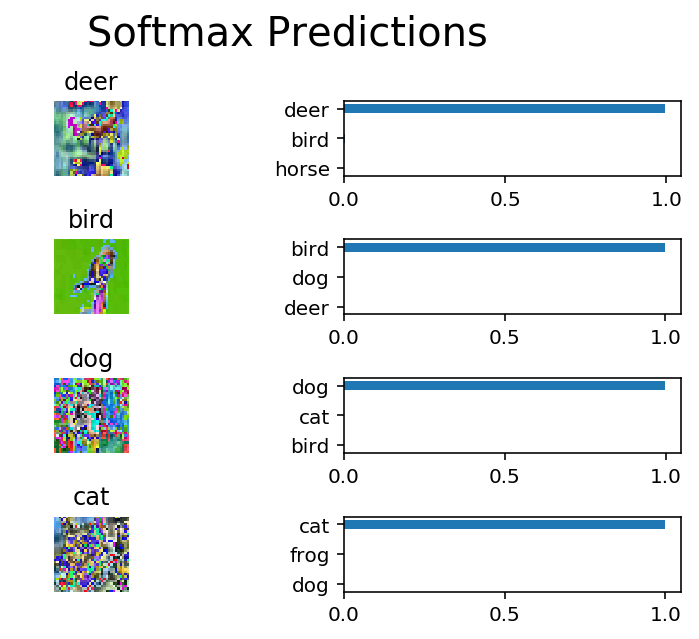

In [19]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import tensorflow as tf
import pickle
import helper
import random

batch_size = 64

save_model_path = './image_classification'
n_samples = 4
top_n_predictions = 3

def test_model():
    """
    Test the saved model against the test dataset
    """
    test_features, test_labels = pickle.load(open('preprocess_test.p', mode='rb'))
    loaded_graph = tf.Graph()

    with tf.Session(graph=loaded_graph) as sess:
        # Load model
        loader = tf.train.import_meta_graph(save_model_path + '.meta')
        loader.restore(sess, save_model_path)

        # Get Tensors from loaded model
        loaded_x = loaded_graph.get_tensor_by_name('x:0')
        loaded_y = loaded_graph.get_tensor_by_name('y:0')
        loaded_keep_prob = loaded_graph.get_tensor_by_name('keep_prob:0')
        loaded_logits = loaded_graph.get_tensor_by_name('logits:0')
        loaded_acc = loaded_graph.get_tensor_by_name('accuracy:0')
        loaded_train_flag = loaded_graph.get_tensor_by_name('train_flag:0')
        
        # Get accuracy in batches for memory limitations
        test_batch_acc_total = 0
        test_batch_count = 0
        
        for test_feature_batch, test_label_batch in helper.batch_features_labels(test_features, test_labels, batch_size):
            test_batch_acc_total += sess.run(loaded_acc,
                feed_dict={loaded_x: test_feature_batch, loaded_y: test_label_batch, loaded_keep_prob: 1.0, loaded_train_flag:False})
            test_batch_count += 1

        print('Testing Accuracy: {}\n'.format(test_batch_acc_total/test_batch_count))

        # Print Random Samples
        random_test_features, random_test_labels = tuple(zip(*random.sample(list(zip(test_features, test_labels)), n_samples)))
        random_test_predictions = sess.run(tf.nn.top_k(tf.nn.softmax(loaded_logits), top_n_predictions),
            feed_dict={loaded_x: random_test_features, loaded_y: random_test_labels, loaded_keep_prob: 1.0, loaded_train_flag:False})
        helper.display_image_predictions(random_test_features, random_test_labels, random_test_predictions)

test_model()